In [ ]:
pip install librosa pretty_midi music21 numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.4 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=156fe7549b2e0545318f81611e55dbbd54f8d23b443988d1366bef0d58054cbf
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import librosa.core

In [ ]:
audio_path = "/content/audio.mp3"
# y, sr = librosa.load(audio_path)

# y = librosa.effects.preemphasis(y)  # Enhance main frequencies
# y = librosa.util.normalize(y)  # Normalize volume
# y, _ = librosa.effects.trim(y, top_db=30)  # Remove silence

# pitch, mag = librosa.core.piptrack(y=y, sr=sr, threshold=0.1)

# melody = []
# for t in range(pitch.shape[1]):
#  if np.max(mag[:, t]) > 0.1:  # Ignore low-energy frames
#     index = np.argmax(mag[:, t])
#     freq = pitch[index, t]
#     melody.append(freq if 50 < freq < 5000 else 0)  # Ignore extreme values
#  else:
#     melody.append(0)  # Add silence

# #melody_midi = librosa.hz_to_midi(np.array(melody))#

# melody_midi = np.round(librosa.hz_to_midi(np.array(melody)))
# melody_midi = np.clip(melody_midi, 21, 108)  # Keep within piano range (A0 - C8)


/usr/local/lib/python3.11/dist-packages/librosa/core/convert.py:1095: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69


In [ ]:
import librosa
import numpy as np
import pretty_midi

def extract_melody(audio_path):
    y, sr = librosa.load(audio_path)

    y = librosa.effects.preemphasis(y)
    y = librosa.util.normalize(y)
    y, _ = librosa.effects.trim(y, top_db=30)

    pitch = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

    melody = []
    for t in range(len(pitch)):
        freq = pitch[t]
        melody.append(freq if 50 < freq < 5000 else 0)  # Ignore noise

    melody_midi = np.round(librosa.hz_to_midi(np.array(melody)))
    melody_midi = np.clip(melody_midi, 21, 108)  # Keep within piano range

    return melody_midi, librosa.get_duration(y=y, sr=sr) / len(melody_midi)  # Return time per note

def melody_to_midi(melody_midi, note_duration, output_midi="output.mid"):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    start_time = 0.0
    prev_note = None
    note_start_time = start_time

    for i, note in enumerate(melody_midi):
        if note == prev_note:  # Extend previous note
            continue
        if prev_note is not None and prev_note > 0:
            midi_note = pretty_midi.Note(velocity=100, pitch=int(prev_note), start=note_start_time, end=start_time)
            instrument.notes.append(midi_note)

        note_start_time = start_time  # Start of new note
        prev_note = note
        start_time += note_duration  # Move time forward

    if prev_note > 0:  # Add the last note
        midi_note = pretty_midi.Note(velocity=100, pitch=int(prev_note), start=note_start_time, end=start_time)
        instrument.notes.append(midi_note)

    pm.instruments.append(instrument)
    pm.write(output_midi)
    print(f"Saved MIDI as {output_midi}")

# Run the pipeline
audio_path = "/content/audio.mp3"
melody_midi, note_duration = extract_melody(audio_path)
melody_to_midi(melody_midi, note_duration)


Saved MIDI as output.mid


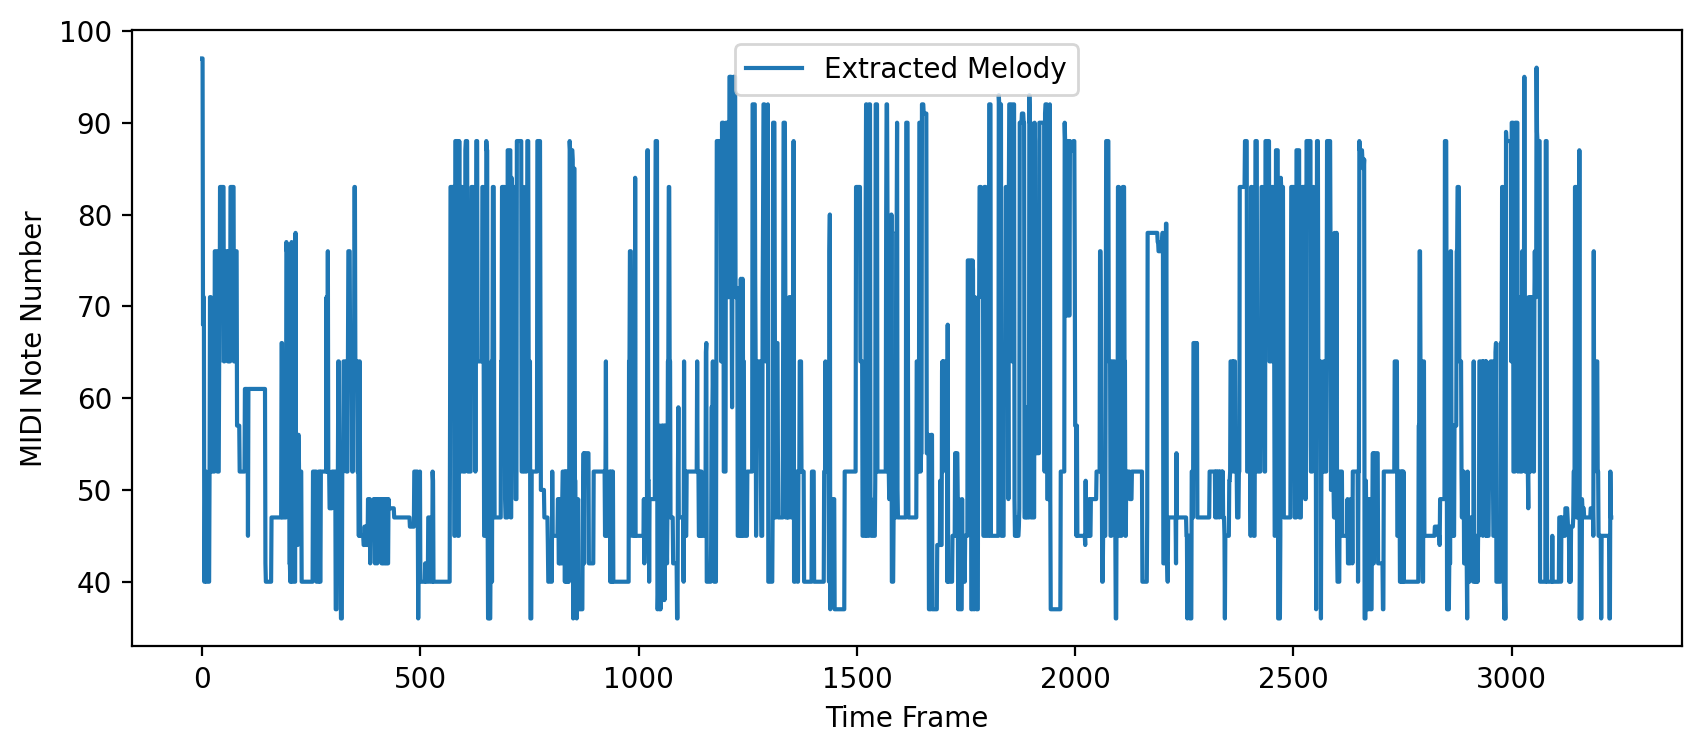

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(melody_midi, label="Extracted Melody")
plt.xlabel("Time Frame")
plt.ylabel("MIDI Note Number")
plt.legend()
plt.show()

In [ ]:

# import pretty_midi

# def melody_to_midi(melody_midi, output_file = "melody.mid"):
#   midi = pretty_midi.PrettyMIDI()
#   instrument = pretty_midi.Instrument(program=0)

#   start_time = 0.0
#   for note in melody_midi:
#     if note > 0:
#       midi_note = pretty_midi.Note(velocity=127, pitch=int(note), start=start_time, end=start_time + 0.5
#       )
#       instrument.notes.append(midi_note)
#     start_time += 0.5

#   midi.instruments.append(instrument)
#   midi.write(output_file)
#   print(f"Saved MIDI file as {output_file}")

# melody_to_midi(melody_midi)

Saved MIDI file as melody.mid


In [ ]:
from music21 import stream, note

def midi_to_sheet(midi_notes, output_file = "melody.xml"):
  score = stream.Stream()
  for midi_note in midi_notes:
    if midi_note > 0:
      n = note.Note()
      n.pitch.midi = int(midi_note)
    else:
      n = note.Rest()  # Add a rest for silent parts

  score.append(n)

  score.write("musicxml", output_file)
  print(f"Saved music21 score as {output_file}")

midi_to_sheet(melody_midi)

Saved music21 score as melody.xml


In [ ]:
import IPython.display as ipd
ipd.Audio("melody.mid")